## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np


#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf
import tensorflow_datasets as tfds

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

#append path with python modules
import importlib
import sys
sys.path.append("../modules")
sys.path.append("/home/akalinow/scratch/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import emnist_functions as emnist_fcn
importlib.reload(emnist_fcn);
#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

Istnieje, niekompletny, zbiór standardowych operacji jakie wykonujemy na różnego typu danych zanim zostaną użyte jako wejście do modelu.
API Keras dostarcza gotowych warstw wykonujących wiele z tych [operacji](https://www.tensorflow.org/guide/keras/preprocessing_layers).
W tym notatniku użyjemy kilku z nich dla różnych rodzajów danych: **numerycznych**, **tekstowych**, **obrazów**.

## Dane numeryczne

### Normalizacja

Standardowa operacja, jaką wykonujemy na danych numerycznych przez podaniem ich na wejście modelu to normalizacja.
Normalizacja powoduje że rząd wielkości wag jest podobny dla wszystkich cech, a same wagi nei są zbyt duże.

```Python

normalization = tf.keras.layers.Normalization(mean, variance) # Normalizacja danych do średniej mean i wariancji wariance
                                                               # domyślnie mean=0, variance=1
                                                               # normalizacja przebiega dla każdej cechy oddzielnie
                                                               # wymaga ustalenia współczynników normalizacji przez metodę adapt(x)
normalization.adapt(x)                                                             
```


**Proszę:**

* wygenerować zbiór `(n,4)` liczb pochodzących z rozkładu płaskiego w zakresach `[[-5,5],[-4,2],[2,2]]`
* wypisać na ekran wartości minimalne, maksymalne  i średnią cech w zbiorze
* znormalizować dane do zakresu `[0,1]` dla każdej cechy oddzielnie
* wypisać na ekran wartości minimalne, maksymalne  i średnią cech w znormalizowanym zbiorze
* sprawdzić czy normalizacja zadziałała zgodnie z oczekiwaniem

In [2]:
n = 10_000
#BEGIN_SOLUTION
x = tf.random.uniform([n, 3])
scales = np.array([[-5,5],[-4,2],[2,2]])
ranges = scales[:,1] - scales[:,0]
x = x * ranges + scales[:,0]
print(colored("min =", "blue"), tf.math.reduce_min(x, axis=0).numpy())
print(colored("mean =", "blue"), tf.math.reduce_mean(x, axis=0).numpy())
print(colored("max =", "blue"), tf.math.reduce_max(x, axis=0).numpy())
print(colored("stddev =", "blue"), tf.math.reduce_std(x, axis=0).numpy())
normalization = tf.keras.layers.Normalization()
normalization.adapt(x)
x = normalization(x)
print(colored("min =", "blue"), tf.math.reduce_min(x, axis=0).numpy())
print(colored("mean =", "blue"), tf.math.reduce_mean(x, axis=0).numpy())
print(colored("max =", "blue"), tf.math.reduce_max(x, axis=0).numpy())
#END_SOLUTION


min = [-4.9996176 -3.9995687  2.       ]
mean = [-0.01494528 -0.97738516  2.        ]
max = [4.9994955 1.9993782 2.       ]
stddev = [2.8904958 1.7489424 0.       ]
min = [-1.7245042 -1.7280062  0.       ]
mean = [ 1.3542175e-08 -2.0980835e-09  0.0000000e+00]
max = [1.7348031 1.7020363 0.       ]



### Dyskretyzacja 

Czasami użyteczne jest podział danych numerycznych na kategorie - **dyskretyzacja**.
Np. wartości możemy podzielić na `małe`, `średnie` i `duże` jeśli nie potrzebujemy dużej rozdzielczości.
Redukcja rozdzielczości z poziomu zmiennoprzecinkowego do listy kategorii może ułatwić trening.

```Python

discretization = tf.keras.layers.Discretization(num_bins, bin_boundaries, output_mode) 
                 # Zamiana zmiennej ciągłej na dyskretną w postaci:
                 # output_mode = int - numer przedziału (wartość domyślna)
                 #               one_hot - wektor typu kodowania gorącojedynkowego
                 # num_bins - liczba przedziałów (wymaga zawołania metody adapt(x))
                 # bin_boundaries - zakresy przedziałów
```

**Proszę:**

* zdyskretyzować dane z poprzedniej komórki do 10 przedziałów
* narysować histogram numerów przedziałów dla **wszystkich** cech
* w histogramie użyć granic przedziałów znalezionych przez `tf.keras.layers.Discretization(...)`:
```Python

discretization.bin_boundaries
```

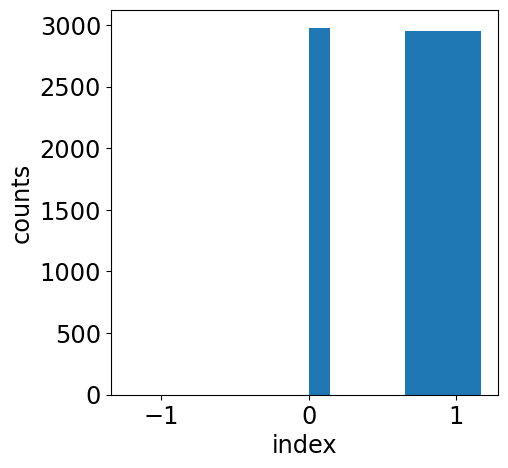

In [3]:
#BEGIN_SOLUTION
discretization = tf.keras.layers.Discretization(num_bins = 10)
discretization.adapt(x)
x = discretization(x)

fig, axis = plt.subplots(1,1, figsize=(5,5))
axis.hist(tf.reshape(shape=(-1,), tensor=x), bins = discretization.bin_boundaries)
axis.set_xlabel('index')
axis.set_ylabel('counts')
#END_SOLUTION
pass

## Dane tekstowe

Zamiana tekstu na postać cyfrową może być wykonana na wiele sposobów. Dwa najbardziej popularne to:
* **wektoryzacja (ang. text vectorization)** - każdemu znacznikowi (ang. `token`) jest przypisana liczba całkowita, indeks w słowniku. 
                 Odwzrorowanie   ${\mathrm tekst}  \leftrightarrow {\mathrm indeks}$ jest ustalane na podstawie zawartości zbioru danych. 

* **zanurzanie (ang. embedding)** - każdemu znacznikowi jest przypisany n-wymiarowy wektor liczb zmiennoprzecinkowych.
    Odwzrorowanie   ${\mathrm tekst}  \leftrightarrow {\mathrm indeks}$ jest znajdowanie w czasie treningu modelu.

### Wektoryzacja

```Python
tf.keras.layers.TextVectorization(
    max_tokens=None,                           # maksymalna liczba znaczników w słowniku
    standardize='lower_and_strip_punctuation', # algorytm standaryzacji tekstu
    split='whitespace',                        # algorytm podziału na słowa
    ngrams=None,                               # algorytm podziału słów na n-literowe fragmenty 
    output_mode='int',                         # typ wyjścia   
    output_sequence_length=None,               # maksymalna długość zakodowanej sekwencji "zdania" 
    pad_to_max_tokens=False,                   # czy dopełniać sekwencję zerami do maksymalnej długości
    vocabulary=None                            # słownik. Jeśli nie jest podany generacja słownika wymaga zawołania
                                               # metody adapt()
)
 ```

 Znaczniki nie występujące w słowniku otrzymają ten sam indeks oznaczający znacznik OOV (`ang. out of vocabulary`) 

**Proszę:**

* zbudować słownik na tekście zawartym w pliku **FIXME**
* zwektoryzować teskt `Król zasiada na tronie.`
* wypisać na ekran zwektoryzowaną postać
* przeprowadzić operację odwrotną - z postaci zwektoryzowanej odtworzyć tekst
* powtórzyć procedurę dla tekstu `Ania ma małego kotka.`

**Wskazówki**: 
* słownik utworzony przez warstwę `tf.keras.layers.TextVectorization` uzyskujemy przez metodę `get_vocabulary()`
* z elementów sekwencji `words` można utworzyć napis w następujący sposób:
```Python
sentence = " ".join(words)
```


In [ ]:

import glob 
filePath = "scratch/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/data/wksf/Korpus_surowy/"
filePath = "../data/wksf/Korpus_surowy/"

fileList = glob.glob(filePath + "/*.txt")
print(fileList)
dataset = tf.data.TextLineDataset(fileList)
dataset = dataset.filter(lambda x: not tf.strings.regex_full_match(x, ".*[~].*"))
dataset = dataset.filter(lambda x: not tf.strings.regex_full_match(x, ".*[<].*"))
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "\[[0-9]+\]", "", replace_global=True))

vectorize_layer = tf.keras.layers.TextVectorization(output_mode = "int")
vectorize_layer.adapt(dataset.batch(128))

item = next(iter(dataset))

for item in dataset.take(5):
    print(item.numpy().decode("utf-8"))


In [ ]:
#BEGIN_SOLUTION
text = 'Król zasiada na tronie.'
#text = 'Królowa zasiada na tronie.'
#text = 'Ania ma małego kotka.'
encoded = vectorize_layer(tf.constant(text))
print(colored("Encoded:", "blue"), encoded.numpy())

vocabulary = vectorize_layer.get_vocabulary()
vocab_arr = np.array(vocabulary) 
decoded = " ".join(vocab_arr[encoded.numpy()])
print(colored("Decoded: ", "blue"), decoded)
#END_SOLUTION
pass

### Zanurzanie


```Python
tf.keras.layers.Embedding(
    input_dim,                          # rozmiar słownika - liczba znaczników ("tokenów")
    output_dim,                         # wymiar reprezentacji  
)
```

Warstwa zanurzająca przypisuje wartość zmiennoprzecinkową każdemu znacznikowi.
Taką operację można reprezentować przez macierz `(output_dim, input_dim)` która działa na wektor gorącojedynkowy o długości `(input_dim)`.
Tutaj `output_dim=3`:

$$
\huge{
\begin{bmatrix}
a_{0} & b_{0} & c_{0} & \dots \\
a_{1} & b_{1} & c_{1} & \dots \\
a_{2} & b_{2} & c_{2} & \dots \\
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\
0 \\
0 \\
\dots \\
0
\end{bmatrix}
=
\begin{bmatrix}
a_{0} \\
a_{1} \\
a_{2} 
\end{bmatrix}
}
$$
Warstwa `tf.keras.layers.Enbedding()` realizuje tę operację w sposób zoptymalizowany.
Macierz zanurzania jest zwykle zmieniana w trakcie treningu modelu który ją zawiera, więc nie jest to standardowa warstwa wstępnego przetwarzania.


**Proszę:**

* zwektoryzować teskt `Król zasiada na tronie.`
* zwektoryzowaną postać podać na wejście warstwy zanurzającej z `nDims = 4`
* wypisać na ekran obie postacie tekstu

In [ ]:
#BEGIN_SOLUTION
nTokens = len(vocabulary)
nDims = 4 
embedding_layer = tf.keras.layers.Embedding(nTokens, nDims)

text = 'Król zasiada na tronie.'
#text = 'Królowa zasiada na tronie.'
encoded = vectorize_layer(tf.constant(text))
print(colored("Encoded:", "blue"), encoded.numpy())
print(colored("Embedding layer: ", "blue"), embedding_layer(encoded).numpy())
#END_SOLUTION
pass

## Obrazy

**Proszę:**

* korzystając z biblioteki `tensorflow_datasets` załadować zbiór `imagenette/160px`
* narysować kilka przykładowych rysunków

In [ ]:
#BEGIN_SOLUTION
ds, ds_info = tfds.load('imagenette/160px', split='train', with_info=True)
fig = tfds.show_examples(ds, ds_info, rows=1, cols=3);
#END_SOLUTION
pass


## Przycinane

z całego obrazu jest wycinany fragment, `ramka`:


```Python
tf.keras.layers.CenterCrop(
    height, width              # szerokość i wysokość prostokąta wycinającego 
                               # fragment w środku obrazu
)
```

Przycinanie w losowym miejscu może być użyte do wzbogacania próbki, poprzez generację
losowych fragmentów obrazu - ang. `augmenting`. Warstwy wykonujące losowe operacje na obrazach
są domyślnie aktywne tylko w czasie treningu.

```Python
tf.keras.layers.RandomCrop(
    height, width, seed=None,  # szerokość i wysokość prostokąta wycinającego 
                               # fragment w losowym miejscu
                               #
)
```



### Skalowanie

Zmiana rozdzielczości - skalowanie obrazu. Skalowanie wymaga podania algorytmu interpolacji, pozwalającego
na obliczenie wartości pikseli w nowym obrazie.

```Python
tf.keras.layers.Resizing(
    height, width,                # szerokość i wysokość nowego obrazu
    interpolation='bilinear',     # algorytm interpolacji
    crop_to_aspect_ratio=False,   # przycinanie obrazu w celu uzyskania
                                  # tego samego stosunku szerokość/długość
                                  # jak w obrazie oryginalnym
)
```



### Translacja

```Python
tf.keras.layers.RandomTranslation(
    height_factor,                  # względny współczynnik przesunięcia w pionie: (min, max)
    width_factor,                   # względny współczynnik przesunięcia w poziomie: (min, max)
    fill_mode='reflect',            # algorytm wypełnienia przestrzeni powstałej po przesunięciu obrazu
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,                 # wartość piksela użytego do wypełniania przestrzeni powstałej po przesunięciu obrazu,
                                    # jeśli jako `fill_mode=constant`
)
```




### Obrót

```Python
tf.keras.layers.RandomRotation(
    factor,                         # zakres obrotu w jednostkach 2pi: (min, max)
    fill_mode='reflect',            # algorytm wypełnienia przestrzeni powstałej po obrocie obrazu
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,                 # wartość piksela użytego do wypełniania przestrzeni powstałej po przesunięciu obrazu,
                                    # jeśli jako `fill_mode=constant`
)
```



**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:
* przycinaniu do obszaru centralnego o rozmiarze `(64,64)`

**Wskazówki:**
* należy użyć metody `tf.data.Dataset.map()` z odpowiednią funkcją mapowania opartą o `tf.keras.layers.CenterCrop`
* uwaga na typ danych w tensorze zawierającym przetworzone obrazy

In [ ]:
#BEGIN_SOLUTION
ds_crop = ds.map(lambda x: {"image": tf.keras.layers.CenterCrop(64,64, dtype=tf.uint8)(x["image"]), "label": x["label"]})
tfds.show_examples(ds_crop, ds_info, rows=1, cols=3);
#END_SOLUTION
pass

**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:
* skalowaniu przyciętego obszaru do rozdzielczości `(320,320)`
* wypisać na ekran rozdzielczość pierwszego przykładu

**Wskazówki:**
* należy użyć metody `tf.data.Dataset.map()` z odpowiednią funkcją mapowania opartą o odpowiednią warstwę
* uwaga na typ danych w tensorze zawierającym przetworzone obrazy

In [ ]:
#BEGIN_SOLUTION
ds_crop = ds
ds_resize = ds_crop.map(lambda x: {"image": tf.keras.layers.Resizing(320,320, crop_to_aspect_ratio=True, dtype=tf.uint8)(x["image"]), "label": x["label"]})

tfds.show_examples(ds_resize, ds_info, rows=1, cols=3)
item = next(iter(ds_resize))
x_res = item["image"].shape[0]
y_res = item["image"].shape[1]
print(colored("Resolution: ", "blue"), x_res, y_res)          
#END_SOLUTION
pass

**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:

* losowemu przycinaniu do obszaru o rozmiarze `(64,64)`

**Wskazówki:**
* użycie warstwy w definicji funkcji lambda spowoduje błędy. Proszę spróbować zinterpretować komunikat o błędzie i odpowiednio skorygować kod.


In [ ]:
#BEGIN_SOLUTION
layer = tf.keras.layers.RandomCrop(64,64, dtype=tf.uint8)
ds_randomCrop = ds.map(lambda x: {"image": layer(x["image"]), "label": x["label"]})
tfds.show_examples(ds_randomCrop, ds_info, rows=1, cols=3);
#END_SOLUTION
pass

**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:

* losowemu obrotowi w zakresie $\pm \pi/4$
* puste miejsca po obrocie proszę wypełnić kolorem czarnym

**Wskazówki:**
* użycie warstwy w definicji funkcji lambda spowoduje błędy. Proszę spróbować zinterpretować komunikat o błędzie i odpowiednio skorygować kod.


In [ ]:
#BEGIN_SOLUTION
layer = tf.keras.layers.RandomRotation(1/8.0, fill_mode='constant',  dtype=tf.uint8)
ds_randomRotation = ds.map(lambda x: {"image": layer(x["image"]), "label": x["label"]})
tfds.show_examples(ds_randomRotation, ds_info, rows=1, cols=3);
#END_SOLUTION
pass

# Zadanie domowe


In [ ]:
window_size = 2
max_window_end = 5

###################################################
def map_fn(x):
    start = tf.random.uniform(shape=[], maxval = max_window_end-window_size, dtype=tf.int32)
    end = start + window_size
    features =  tf.concat((x[:,start:end], x[:,end+1:end+1+window_size]), axis=1)
    label = x[:,end]

    return features, label
###################################################
def print_item(batch, vocabulary):
    batch_index = 0
    item = (batch[0][batch_index], batch[1][batch_index])
    features = " ".join(vocabulary[item[0].numpy()[0:window_size]])
    label = vocabulary[item[1].numpy()]   
    print(colored("Features", "blue"), end=" ")
    print(colored("(Label):", "red"), end=" ")

    print(features, end=" ")
    print(colored(label,"red"), end=" ")
    features = " ".join(vocabulary[item[0].numpy()[window_size:]])
    print(features)
################################################### 

In [ ]:
filePath = "scratch/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/data/wksf/Korpus_surowy/"
fileList = glob.glob(filePath + "/*.txt")

fileList = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

print(colored("Input file list:", "blue"), fileList)
dataset = tf.data.TextLineDataset(fileList)

#Remove lines with special characters
dataset = dataset.filter(lambda x: not tf.strings.regex_full_match(x, ".*[~].*"))
dataset = dataset.filter(lambda x: not tf.strings.regex_full_match(x, ".*[<].*"))
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "\[[a-zA-Z0-9*]+\]", "", replace_global=True))
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "\[/\]", "", replace_global=True))

#Vectorize
vectorize_layer = tf.keras.layers.TextVectorization(output_mode = "int", output_sequence_length = 10)
vectorize_layer.adapt(dataset)
vocabulary = np.array(vectorize_layer.get_vocabulary())
vocabulary_length = vocabulary.shape[0] 
dataset_vectorized = dataset.batch(1024).map(vectorize_layer, num_parallel_calls=tf.data.AUTOTUNE).unbatch()
print(colored("Vocabulary length: ", "blue"), vocabulary_length)

#Remove short texts
dataset_filtered = dataset_vectorized.filter(lambda x: tf.math.count_nonzero(x) > max_window_end)

#Tokenize 
batchSize = 32
ds_tokenized = dataset_filtered.batch(batchSize).map(map_fn)

# print a few examples
# Text
for batch in dataset.batch(batchSize).take(3):
    print(colored("Original text: ", "blue"), batch[0].numpy().decode("utf-8"))

#Features and label
for batch in ds_tokenized.take(3):
    print_item(batch, vocabulary)

#Benchmark
tfds.benchmark(ds_tokenized, batch_size=batchSize)

In [ ]:
# Load the dataset
batchSize = 32
directory = "/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/data/Wikipedia_PL/"
directory = "/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/data/Wikipedia_PL/plwiki3/subsets/Countries/"

dataset = tf.keras.preprocessing.text_dataset_from_directory(directory,
            labels=None, label_mode=None, class_names=None, batch_size=batchSize,
            max_length=None, shuffle=False, seed=None, validation_split=None,
            subset=None, follow_links=False)

#Remove HTML tags
regexp = "<[^>]*>"
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, regexp, "", replace_global=True))

#Vectorize
vectorize_layer = tf.keras.layers.TextVectorization(output_mode = "int", max_tokens=100000)
vectorize_layer.adapt(dataset)
vocabulary = np.array(vectorize_layer.get_vocabulary())
vocabulary_length = vocabulary.shape[0] 
dataset_vectorized = dataset.map(vectorize_layer, num_parallel_calls=tf.data.AUTOTUNE)
print(colored("Vocabulary length: ", "blue"), vocabulary_length)

#Remove short texts
dataset_filtered = dataset_vectorized.filter(lambda x: tf.shape(x)[-1] > max_window_end)

#Tokenize and optimize I/O
ds_tokenized = dataset_filtered.map(map_fn).prefetch(tf.data.AUTOTUNE)

#Print a few examples
#Original text
batch_iter = iter(dataset)
batch = next(batch_iter)
print(colored("Original text: ", "blue"), batch[0].numpy().decode("utf-8"))

#Features and label
for item in ds_tokenized.take(10):
    print_item(item, vocabulary)

#Benchmark
tfds.benchmark(ds_tokenized, batch_size=batchSize)

In [ ]:
 #Define the model
embedding_depth = 128
input_layer = tf.keras.layers.Input(shape=(2*window_size,), dtype=tf.int32)
embedding_layer = tf.keras.layers.Embedding(vocabulary_length, embedding_depth, name="embedding")
context_embedding = embedding_layer(input_layer)
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))
context_mean = tf.math.reduce_mean(context_embedding, axis=1, keepdims=True)
dot_product = tf.math.multiply(context_mean, vocabulary_embedding)
dot_product = tf.math.reduce_sum(dot_product, axis=2)
model = tf.keras.Model(inputs=input_layer, outputs=dot_product)
model.summary()
#tf.keras.utils.plot_model(model, '../fig_png/ML_model.png', show_shapes=True)
tf.keras.utils.plot_model(model, 'ML_model.png', show_shapes=True)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

#Evaluate non trained model
model.evaluate(ds_tokenized.take(16))

#Training 
nEpochs = 100
initial_learning_rate = 2E-2
    
nStepsPerEpoch = 660
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

history = model.fit(ds_tokenized.skip(16), epochs=nEpochs, 
                    validation_data=ds_tokenized.take(16),
                    verbose=0)
    
model.evaluate(ds_tokenized.take(16))    
plf.plotTrainHistory(history)
###################################################

In [ ]:
#Features and label
for batch in ds_tokenized.skip(16).take(5):
    print_item(batch, vocabulary)
    response = tf.math.argmax(model(batch[0]), axis=1)[0]
    print(colored("Response:", "blue"), vocabulary[response])


#Exlore embedding space
embedding_layer = model.get_layer("embedding")
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))

word = "polska"
word_index = np.where(vocabulary == word)[0][0]
word_embedding = vocabulary_embedding[word_index]

print(colored("Word embedding:", "blue"), word_embedding.shape)
print(colored("Vocabulary embedding:", "blue"), vocabulary_embedding.shape)
cosine_similarity = -tf.keras.losses.cosine_similarity(word_embedding, vocabulary_embedding, axis=-1)

top_k = tf.math.top_k(cosine_similarity, k=5)
top_k_indices = top_k.indices.numpy()
top_k_values = top_k.values.numpy() 
top_k_words = vocabulary[top_k_indices]
print(colored("Top 5 words similar to: ", "blue"), word)
for word, distance in zip(top_k_words, top_k_values):
    print(colored("\t"+word+"\t", "red"), distance)

  

In [ ]:
class CBOW(tf.keras.Model):
  def __init__(self, vocab_length, embedding_depth):
    super().__init__(self)
    self.embedding_layer = tf.keras.layers.Embedding(vocab_length, embedding_depth, name='embedding')
    self.output_layer = tf.keras.layers.Dense(vocab_length, activation='softmax')
   
  def call(self, input, training=True):
    input_embedding = self.embedding_layer(input)
    output = tf.reduce_mean(input_embedding, axis=1)
    output = self.output_layer(output)
    return output

inputs = tf.keras.layers.Input(shape=(2*window_size,), dtype=tf.int32)

model = CBOW(vocabulary_length=vocabulary_length, embedding_depth=embedding_depth)
batch = next(iter(ds_tokenized))
model(batch)
model.summary()
tf.keras.utils.plot_model(model, 'ML_model.png', show_shapes=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

###Training
nEpochs = 20
initial_learning_rate = 1E-3
batchSize = 32
    
nStepsPerEpoch = int(9984/batchSize)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

#run training
history = model.fit(ds_tokenized.skip(16), epochs=nEpochs, 
                    validation_data=ds_tokenized.take(16),
                    verbose=1)
    
plf.plotTrainHistory(history)
###################################################

In [ ]:
def dump_embedding(model, vocabulary):
  import io
  out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
  out_m = io.open('metadata.tsv', 'w', encoding='utf-8')
  weights = model.get_layer('embedding').get_weights()[0]
  for index, word in enumerate(vocabulary):
    if index == 0:
      continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
  out_v.close()
  out_m.close()

dump_embedding(model, vocabulary)